In [1]:
import numpy as np
import sklearn as sk
import sklearn.linear_model as sklm
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io
import h5py
import sys
# import pickle # save into bytes file

sys.path.append('../Metric/')
sys.path.append('../../Visualization/')
from Metric import *
from Visualization import *
from Data_Extractor import *

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load & Construct training & test set:

In [2]:
# Load
path_raw_image = "../../Data/090085/090085_20170531.h5"
path_road_mask = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/motor_trunk_pri_sec_tert_uncl_track.tif"
path_topleft_coordinate = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/posneg_topleft_coordinate_8"

raw_image = np.array(h5py.File(path_raw_image)['scene'])
road_mask = skimage.io.imread(path_road_mask)

data = h5py.File(path_topleft_coordinate, 'r')

pos_topleft_coord = np.array(data['positive_example'])
neg_topleft_coord = np.array(data['negative_example'])
data.close()

print(raw_image.shape, road_mask.shape)

# Construct training & test set
pos_size = pos_topleft_coord.shape[0]
neg_size = neg_topleft_coord.shape[0]
print("pos=", pos_size, "neg=", neg_size)

(7, 7961, 8091) (7961, 8091)
pos= 374365 neg= 25134009


In [ ]:
Train_Data = Data_Extractor (raw_image, road_mask, 8,
                             pos_topleft_coord = pos_topleft_coord[:int(0.75*pos_size) ,:],
                             neg_topleft_coord = neg_topleft_coord[:int(0.75*neg_size) ,:])

Test_Data  = Data_Extractor (raw_image, road_mask, 8,
                             pos_topleft_coord = pos_topleft_coord[ int(0.75*pos_size):int(0.90*pos_size),:],
                             neg_topleft_coord = neg_topleft_coord[ int(0.75*neg_size):int(0.90*neg_size),:])

print("train: pos = ", Train_Data.pos_size, Train_Data.neg_size)
print("test: pos = ", Test_Data.pos_size, Test_Data.neg_size)

Model parameters: 

In [3]:
width = 8
height = 8
band = 7

batch_size = 64
learning_rate = 9e-6
epoch = 15
iteration = int(Train_Data.size / batch_size) + 1

# emphasize on pos example
log_classifier = sklm.SGDClassifier(loss='log', max_iter=1, 
                                    class_weight={0:Train_Data.pos_size/Train_Data.size,
                                                  1:Train_Data.neg_size/Train_Data.size})
all_classes = np.array([0, 1])
print(log_classifier)

NameError: name 'Train_Data' is not defined

In [5]:
model_path = './Result/moto_trunk_pri_sec_tert_uncl_track/sklearn - central pixel/'
model_name = 'sklearn_weighted_pos0'

Train & monitor:

In [ ]:
learning_curve = []
for epoch_num in range(epoch):
    for iter_num in range(iteration):

        batch_x, batch_y = Train_Data.get_patches(batch_size=batch_size, positive_num=8, norm=True)
        batch_x = batch_x.reshape((batch_size, -1))
        
        log_classifier.partial_fit(batch_x, batch_y, all_classes)

    # snap shot
    cost = log_classifier.decision_function(batch_x).mean()
    learning_curve.append(cost)
    print("acc = ", log_classifier.score(batch_x, batch_y), " cross entropy = ", cost)

print("finish")

In [ ]:
# plot training curve
plt.figsize=(9,5)
plt.plot(learning_curve)
plt.title('learning_curve')
plt.show()

(Optional) Save the model

In [ ]:
from sklearn.externals import joblib
joblib.dump(log_classifier, model_path+model_name) 

saved_sk_obj = joblib.load(model_path+model_name)
assert (saved_sk_obj.coef_ == log_classifier.coef_).all()

Reload model

In [ ]:
# reload
from sklearn.externals import joblib
log_classifier = joblib.load(model_path+model_name)

Evaluate:

In [ ]:
print(log_classifier.coef_.shape)
print(log_classifier.coef_.max(), log_classifier.coef_.min())
print(log_classifier.coef_)

In [ ]:
train_metric = Metric()

for x, y in Train_Data.iterate_data(norm=True):
    x = x.reshape((1, -1))
    
    # record metric
    pred = log_classifier.predict(x)
    train_metric.accumulate(np.array([pred]), np.array([y]))
    
train_metric.print_info()

In [ ]:
test_metric = Metric()

for x, y in Test_Data.iterate_data(norm=True):
    x = x.reshape((1, -1))
    
    # record metric
    pred = log_classifier.predict(x)
    test_metric.accumulate(np.array([pred]), np.array([y]))
    
test_metric.print_info()

Predict road prob masks

In [ ]:
index = np.where(log_classifier.classes_ == 1)[0][0]
print(log_classifier.classes_, index)

pred_road = np.zeros(road_mask.shape)
for coord, patch in Train_Data.iterate_raw_image_patches_with_coord(norm=True):
    patch = patch.reshape([1,-1])
    
    pred_road[int(coord[0]+width/2), int(coord[1]+width/2)] = log_classifier.predict_proba(patch)[0, index]

In [ ]:
prediction_name = model_name + '_pred.h5'

h5f_file = h5py.File(model_path + prediction_name, 'w')
h5f_file.create_dataset (name='pred_road', data=pred_road)
h5f_file.close()

Load prediction

In [6]:
# restore prediction 
prediction_name = model_name + '_pred.h5'

h5f_file  = h5py.File(model_path + prediction_name, 'r')
pred_road = np.array(h5f_file['pred_road'])
h5f_file.close()

Analyze pred

0.0 1.0 0.03734984751827383


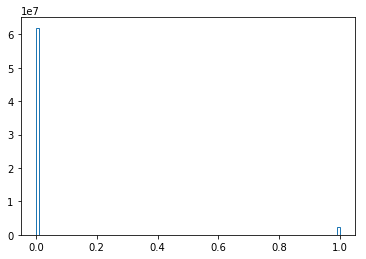

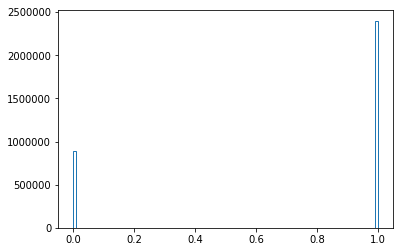

In [7]:
print(pred_road.min(), pred_road.max(), pred_road.mean())
plt.hist(x=pred_road.flatten(), bins=100, histtype='step')
plt.show()
plt.close()
plt.hist(x=pred_road[np.where(pred_road>0)].flatten(), bins=100, histtype='step')
plt.show()
plt.close()

In [ ]:
show_pred_prob_with_raw(raw_image, pred_road, road_mask, pred_weight=0.2, figsize=(50,50), show_plot=True)
#                         save_path=model_path + 'Analysis/prob_road_on_raw - 0_1.png')

Analyze log pred

In [8]:
log_pred = -np.log(-pred_road + 1 + 1e-7)
print(log_pred.min(), log_pred.max(), log_pred.mean())

norm_log_pred = (log_pred - log_pred.min()) / (log_pred.max()-log_pred.min())
print(norm_log_pred.min(), norm_log_pred.max(), norm_log_pred.mean())

-9.999999505838704e-08 16.11809565095832 0.5997394716039092
0.0 1.0 0.037209083558657895


In [ ]:
show_pred_prob_with_raw(raw_image, norm_log_pred,
                        true_road=road_mask, pred_weight=0.2, figsize=(150,150), show_plot=False,
                        save_path=model_path + 'Analysis/log_prob_on_raw - 0_2.png')

In [ ]:
plt.imshow(np.array([[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]), cmap='hot')
plt.show()
plt.figure(figsize=(100,100))
plt.imshow(pred_road, cmap=plt.get_cmap('hot'))
plt.show()
plt.close()

In [ ]:
plt.imshow(np.array([[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]), cmap='hot')
plt.show()
plt.figure(figsize=(100,100))
plt.imshow(np.log(pred_road + 1e-9), cmap='hot')
plt.show()
plt.close()